In [1]:
import os
import datetime

import pandas as pd

from astropy.timeseries import TimeSeries
import astropy.units as u

import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")

OBJ_DATA_DIR = "/home/ramon/uanl/Tesis/Backup Data"
CULLED_OBSV_DATA_FILE = os.path.join(OBJ_DATA_DIR, "culledObjData.csv")
CULLED_OBSV_DATA_FILE

'/home/ramon/uanl/Tesis/Backup Data/culledObjData.csv'

In [2]:
allObjDf = pd.read_csv(CULLED_OBSV_DATA_FILE, index_col=0)
allObjDf

,MAG,MERR,FLUX,FERR,NORM_FLUX,OTIME,obsv_date,julianDate,NORM_FERR,RAPERT
0,17.981,0.031,38512.91,1088.952417,1.026973,2022-10-21 22:54:21.841000-05:00,2022-10-21,2.459874e+06,0.029038,20.0
1,18.061,0.027,35790.91,876.946726,0.954389,2022-10-21 22:55:22.219000-05:00,2022-10-21,2.459874e+06,0.023384,20.0
2,18.024,0.030,37013.54,1011.180591,0.986992,2022-10-21 22:56:22.714000-05:00,2022-10-21,2.459874e+06,0.026964,20.0
3,17.929,0.021,40406.38,776.604189,1.077464,2022-10-21 22:57:23.081000-05:00,2022-10-21,2.459874e+06,0.020709,20.0
4,18.002,0.020,37782.93,702.207615,1.007508,2022-10-21 22:58:23.606000-05:00,2022-10-21,2.459874e+06,0.018725,20.0
...,...,...,...,...,...,...,...,...,...,...
120,18.291,0.013,28951.98,356.052501,0.853835,2022-12-10 20:52:39.875000-06:00,2022-12-10,2.459924e+06,0.010500,9.0
121,18.288,0.017,29047.29,442.997067,0.856646,2022-12-10 20:53:40.007000-06:00,2022-12-10,2.459924e+06,0.013065,9.0
122,18.329,0.021,27972.15,541.056134,0.824938,2022-12-10 20:54:40.156000-06:00,2022-12-10,2.459924e+06,0.015957,9.0
123,18.361,0.016,27142.27,390.640562,0.800464,2022-12-10 20:55:40.318000-06:00,2022-12-10,2.459924e+06,0.011521,9.0


In [3]:
allObjDf['OTIME'] = pd.to_datetime(allObjDf['OTIME'], utc=True)
allObjDf['OTIME']

0     2022-10-22 03:54:21.841000+00:00
1     2022-10-22 03:55:22.219000+00:00
2     2022-10-22 03:56:22.714000+00:00
3     2022-10-22 03:57:23.081000+00:00
4     2022-10-22 03:58:23.606000+00:00
                    ...               
120   2022-12-11 02:52:39.875000+00:00
121   2022-12-11 02:53:40.007000+00:00
122   2022-12-11 02:54:40.156000+00:00
123   2022-12-11 02:55:40.318000+00:00
124   2022-12-11 02:56:40.463000+00:00
Name: OTIME, Length: 1201, dtype: datetime64[ns, UTC]

In [4]:
normalizedTs = TimeSeries(time=allObjDf['OTIME'], 
            data={'mag': allObjDf['MAG']*u.mag, 'err': allObjDf['MERR']*u.mag, 
                  'raw_flux': allObjDf['FLUX']*u.ct, 'ferr': allObjDf['FERR'], 
                  # 'detrend_flux': normalizedDf['FLUX']*u.ct, 
                  'norm_flux': allObjDf['NORM_FLUX'],
                  'obsv_date': allObjDf['obsv_date'], 
                  'julianDate': allObjDf['julianDate']})

In [5]:
normalizedTs.time.jd

array([2459874.66275279, 2459874.66345161, 2459874.66415178, ...,
       2459924.6212981 , 2459924.62199442, 2459924.62269054])

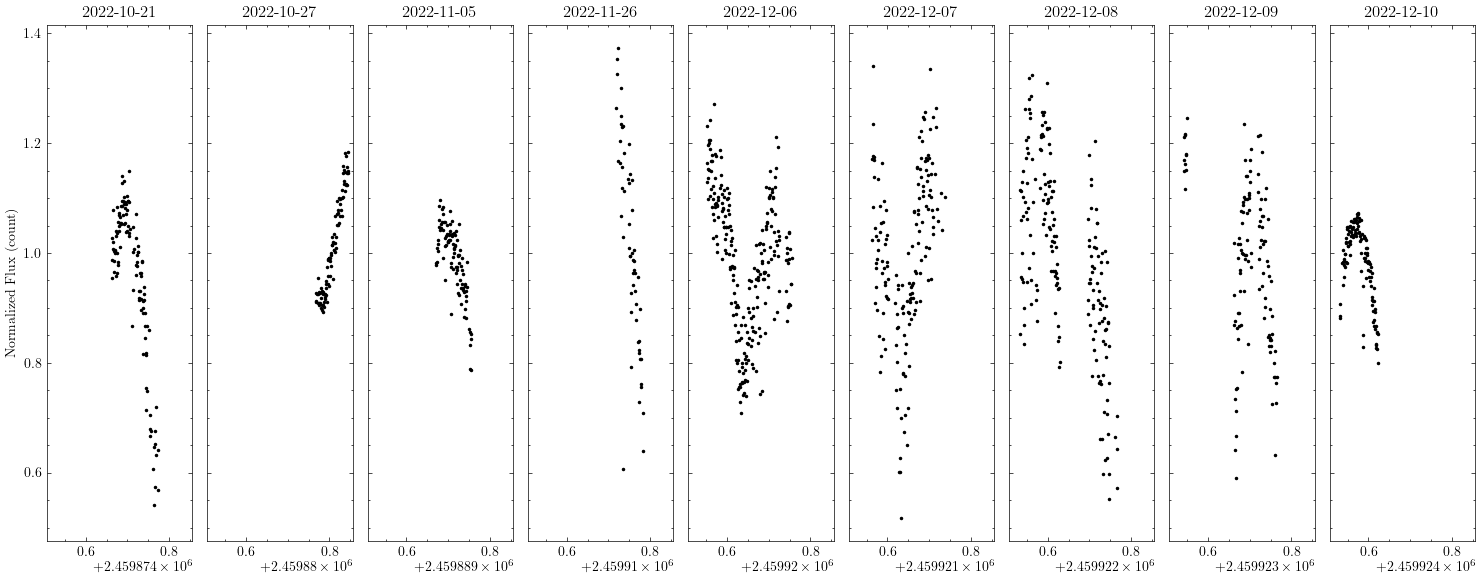

In [6]:
# normalized flux synced in time

# %matplotlib widget

import astropy.units as u
import numpy as np
from astropy.timeseries import TimeSeries
from astropy.time import Time

from dateutil.parser import parse

tsObsvDates = allObjDf['obsv_date'].unique()
fig, axs = plt.subplots(nrows=1, ncols=len(tsObsvDates), sharey=True, figsize=(15, 6))

for d, ax in zip(tsObsvDates, axs):
    dateTs = normalizedTs[normalizedTs['obsv_date'] == d]
    ax.plot(normalizedTs.time.jd, normalizedTs['norm_flux'], 'k.', markersize=3)
    baseMinDayTime = Time(parse(f"{dateTs['obsv_date'][0]}T19:10:00-05:00"))
    baseMaxDayTime = Time(parse(f"{dateTs['obsv_date'][0]}T03:32:00-05:00")) + 1*u.day

    ax.set_xlim(baseMinDayTime.jd, baseMaxDayTime.jd)
    
    ax.set_title(d)

axs[0].set_ylabel("Normalized Flux (count)")
fig.tight_layout()

Text(0, 0.5, 'Duration [h]')

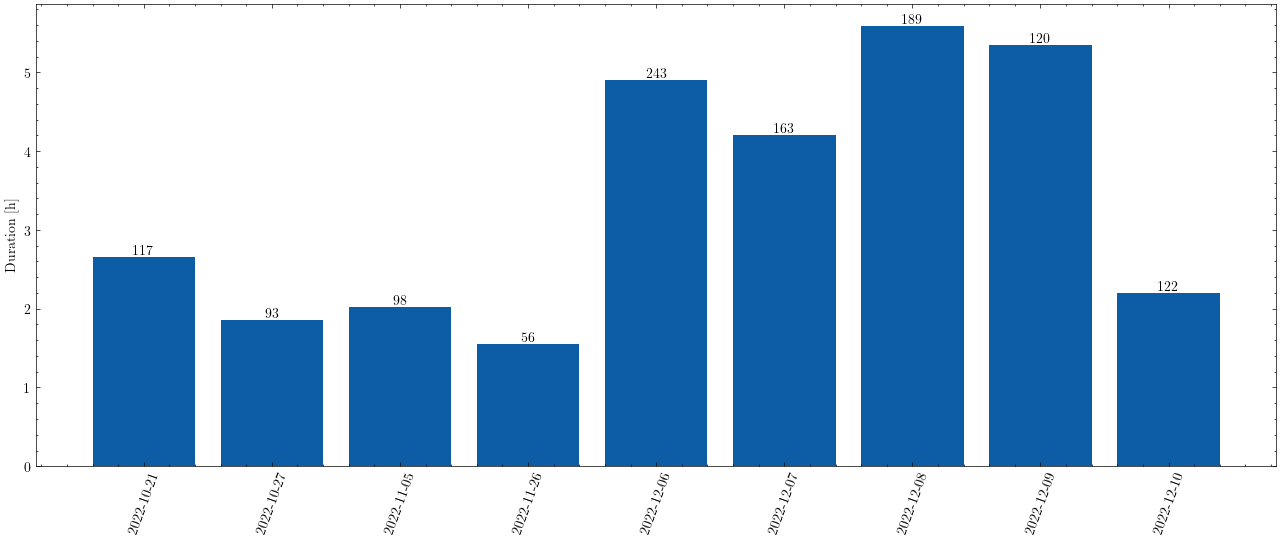

In [7]:
# observation duration bar chart

# %matplotlib widget

import numpy as np

tsObsvDates = allObjDf['obsv_date'].unique()
obsvDatesDurations = []
obsvCounts = []
for i, d in enumerate(tsObsvDates):
    obsvData = allObjDf[allObjDf['obsv_date'] == d]
    obsvStart = obsvData['OTIME'].iloc[0]
    obsvEnd = obsvData['OTIME'].iloc[-1]
    durationHours = (obsvEnd - obsvStart).seconds / 3600
    obsvDatesDurations.append(durationHours)
    obsvCounts.append(len(obsvData))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
ax.bar(np.arange(len(tsObsvDates)), obsvDatesDurations)

rects = ax.patches
for rect, label in zip(rects, obsvCounts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom")

ax.set_xticks(np.arange(len(tsObsvDates)), tsObsvDates, rotation=70)
ax.set_ylabel("Duration [h]")

Periodo: 3.429940680398073 h
Frecuencia: 6.997205560189046 1 / d


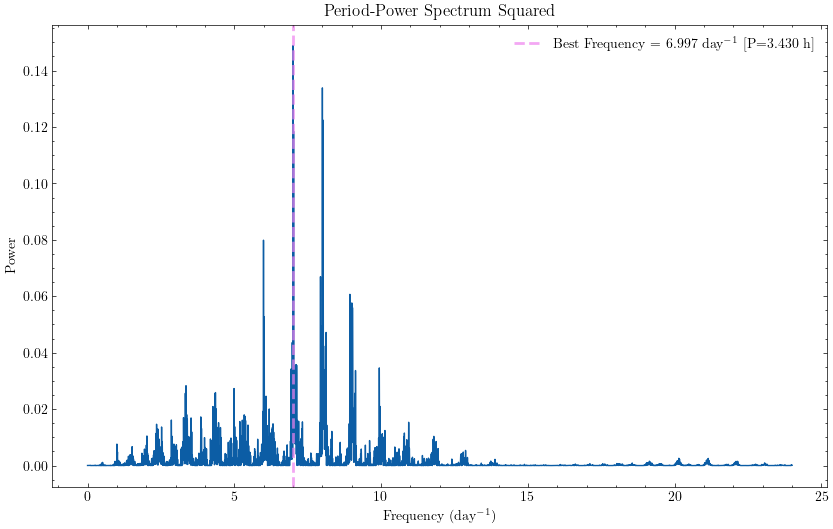

In [12]:
%matplotlib widget

import astropy.units as u
from astropy.timeseries import LombScargle

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

MIN_FREQ = 0.001
# MAX_FREQ = (1 / (2*(60*u.second).to(u.day))).value # windowing limit windowed observations, taking delta-t = 60sec
MAX_FREQ = 24 # 1 hour period

N_0 = 15
GRID_SIZE = N_0 * (normalizedTs.time.jd[-1] - normalizedTs.time.jd[0]) * float(MAX_FREQ)

# setting a much finer grid for lower frequencies, since this is where we expect the orbital period to be
sub1 = np.linspace(MIN_FREQ, MAX_FREQ, int(GRID_SIZE), endpoint=False)
# sub2 = np.linspace(12, float(MAX_FREQ), int(GRID_SIZE) // 100)
# manualFreqSample = np.concatenate([sub1, sub2])
manualFreqSample = sub1

model = LombScargle.from_timeseries(normalizedTs, signal_column_name='norm_flux')
freqs = manualFreqSample * (1/u.day)

explicitPeriodogram = model.power(freqs)
bestFreq = freqs[np.argmax(explicitPeriodogram)]
bestPeriod = 1.0 / bestFreq
ax.plot(freqs, np.power(explicitPeriodogram, 2))
ax.axvline(bestFreq.value, color='violet', linestyle='--', label=f"Best Frequency = {bestFreq.value:0.3f} day$^{{-1}}$ [P={bestPeriod.to(u.hour):0.3f}]", linewidth=2, alpha=0.7)
# ax.axvline(bestFreq.value*2, color='indigo', linestyle='--', label=f"Best Frequency (2nd harmonic) = {bestFreq.value*2:0.3f} day$^{{-1}} [$P={bestPeriod.to(u.hour)*2:0.3f}$]$", linewidth=2, alpha=0.7)

ax.set_title("Period-Power Spectrum Squared")
ax.set_xlabel("Frequency (day$^{-1}$)")
ax.set_ylabel("Power")

ax.legend()
print(f"Periodo: {bestPeriod.to(u.hour)}")
print(f"Frecuencia: {1.0 / bestPeriod}")

In [9]:
%%script echo "skipping for LS; need to figure out transits for LS"

index = np.argmax(explicitPeriodogram.power)

period = explicitPeriodogram.period[index]
transitTime = explicitPeriodogram.transit_time[index]
transitDuration = explicitPeriodogram.duration[index]

periodogramStats = model.compute_stats(period, transitDuration, transitTime)
periodogramStats

skipping for LS; need to figure out transits for LS


In [10]:
%%script echo "skipping for LS; need to figure out transits for LS"

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

ax.plot(objTimeSeries.time.jd, objTimeSeries['flux'], 'k.', markersize=3, label="Original")

i = 0
for tt in periodogramStats['transit_times']:
    if periodogramStats['per_transit_count'][i] != 0 or i % 5 == 0:
        lineColor = "blue" if periodogramStats['per_transit_count'][i] != 0 else "orange"
        ax.axvline(tt.jd, linestyle='--', color=lineColor, alpha=0.5)
    i = i + 1

skipping for LS; need to figure out transits for LS


62


/tmp/ipykernel_23567/2939471550.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar')


Text(0, 0.5, 'Normalized Flux')

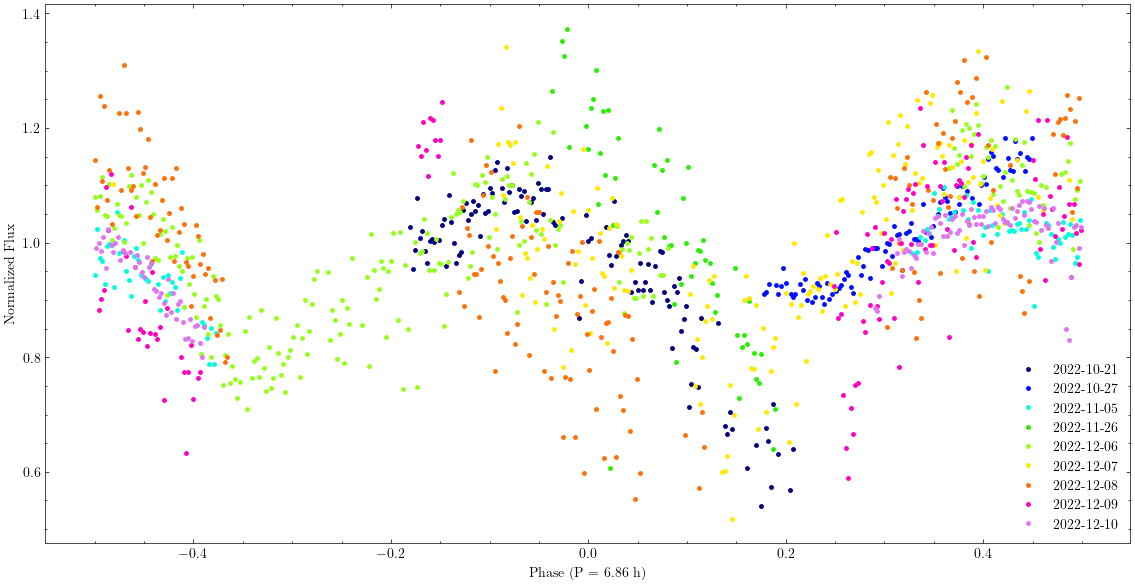

In [25]:
import numpy as np
from matplotlib import cm

# period = 0.124*u.day
periodHarmonic = 2
period = bestPeriod*periodHarmonic

tsObsvDates = allObjDf['obsv_date'].unique()

cmap = cm.get_cmap('gist_ncar')
dateColors = [cmap(c) for c in np.linspace(0.001, 1, len(tsObsvDates), endpoint=False)]

figure, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 7))
minIndex = np.argmin(normalizedTs[normalizedTs['obsv_date'] == tsObsvDates[5]]['raw_flux'])
print(minIndex)
foldedTs = normalizedTs.fold(period=period, epoch_time=normalizedTs.time[minIndex], normalize_phase=True)
for obsvDate, color in zip(tsObsvDates, dateColors):
    obsvPoints = foldedTs[foldedTs['obsv_date'] == obsvDate]
    ax.plot(obsvPoints.time.value, obsvPoints['norm_flux'], '.', color=color, markersize=5, label=obsvDate)
ax.legend()

ax.set_xlabel(f"Phase (P = {period.value * 24:.2f} h)")
ax.set_ylabel("Normalized Flux")